# Import Libraries

In [1]:
import re
import os
import io
import spacy
import string
import numpy as np
import pandas as pd

# Gensim
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import warnings
warnings.filterwarnings('ignore')


# Read and Prepare Dataset

In [2]:
dataset = pd.read_csv("processedcovidvaccinereact.csv", index_col=0)
dataset.shape

(126250, 7)

In [3]:
dataset = dataset.dropna() # drop null values
dataset.shape

(125829, 7)

In [4]:
dataset.head(5)

,TweetDate,TweetText,CleanedTweet,TweetAuthor,TweetLocation,AllHashtags,Country
0,2021-03-17 23:59:34,The only way #COVID19 can mutate with variants...,onli way mutat variant viru replic host peopl ...,kemsunde,Unknown,"['COVID19', 'CovidVaccine', 'GetTheFactsGetThe...",Unknown
1,2021-03-17 23:59:20,I've now officially had my 1st dose of the #Co...,ive offici dose covidvaccin definit worth driv...,ManeckiN,The Wild Western Wastes,"['CovidVaccine', 'COVID19', 'PfizerVaccine', '...",Unknown
2,2021-03-17 23:58:31,@hendopolis Imagine if the #Brexit referendum ...,hendopoli imagin brexit referendum held secret...,raymasseytweets,England,"['Brexit', 'EU', 'TrueColours', 'Impfstoff', '...",United Kingdom
3,2021-03-17 23:58:03,@EICostheta @RicBarraArch1 @insiders Yep. The ...,eicostheta insid yep liarsnparasit veri narrow...,MikeFitzAU,Mudjimba,"['LiarsNParasites', 'CovidVaccine']",Australia
4,2021-03-17 23:57:37,This sounds like an important topic for @NickS...,thi sound like import topic nicksawyermd tnich...,stephjantzen,Greater Sacramento,"['FiresideChat', 'CovidVaccine']",Brazil


In [5]:
text_data = dataset["CleanedTweet"]  # select cleaned tweets column
#text_data = text_data[:100]

In [6]:
text__data =  [text.split() for text in text_data]  # tokenize dataset

In [7]:
len(text__data)

125829

In [9]:
brand_keywords =['Covax','Vax','behalf_covax','Covishield','borisjohnson','johnson','johnsonandjohnson',
           'johnsonandjohnsonvaccine','moderna','modernavaccine','modernapfizer','teammoderna','pfizercovidvaccine',
           'pfizervaccine','pfizer', 'AstraZeneca','bioNtech','Janssen']
brand_keywords = [i.lower() for i in brand_keywords]
print(brand_keywords)
text_data = []
for tweetSentence in text__data:
  
  sent = []
  for tweetWord in tweetSentence:
    if tweetWord in brand_keywords:
        sent.append(tweetWord)
       
  if sent:
    text_data.append(sent)


['covax', 'vax', 'behalf_covax', 'covishield', 'borisjohnson', 'johnson', 'johnsonandjohnson', 'johnsonandjohnsonvaccine', 'moderna', 'modernavaccine', 'modernapfizer', 'teammoderna', 'pfizercovidvaccine', 'pfizervaccine', 'pfizer', 'astrazeneca', 'biontech', 'janssen']


In [10]:
text_data[:10]

[['astrazeneca'],
 ['astrazeneca'],
 ['pfizer'],
 ['astrazeneca'],
 ['pfizer'],
 ['astrazeneca'],
 ['moderna'],
 ['moderna'],
 ['pfizer'],
 ['moderna', 'moderna']]

### Make Bigrams for LDA Model

In [11]:
# Build the bigram models
bigram = gensim.models.Phrases(text_data, min_count=1) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

text_data = [bigram_mod[doc] for doc in text_data]

In [12]:
text_data[:10]

[['astrazeneca'],
 ['astrazeneca'],
 ['pfizer'],
 ['astrazeneca'],
 ['pfizer'],
 ['astrazeneca'],
 ['moderna'],
 ['moderna'],
 ['pfizer'],
 ['moderna', 'moderna']]

# Build Dictionary

In [13]:
# make dictionary of complete corpus
dictionary_LDA = corpora.Dictionary(text_data)
# filter tokens below frequency of 3 words
dictionary_LDA.filter_extremes(no_below=3)
# index to words 
corpus = [dictionary_LDA.doc2bow(tok) for tok in text_data]

# Build LDA Model
# Compute Coherence and Preplexity
# Choose optimal number of topics

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    
    topics_list = [2, 4, 6, 8, 10, 12]
    coherence_values = []
    perplexity_val = []
    model_list = []
    for num_topics in topics_list:
        model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary_LDA, passes=40,iterations =100, alpha=0.05, eta=0.01)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=text_data, dictionary=dictionary_LDA, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_val.append(model.log_perplexity(corpus))

    return model_list, coherence_values, perplexity_val

# Train LDA Model

In [15]:
# Can take a long time to run.
model_list, coherence_values, perplexity_val = compute_coherence_values(dictionary=dictionary_LDA, corpus=corpus, texts=text_data, start=2, limit=40, step=6)

# Plot Coherence Scores

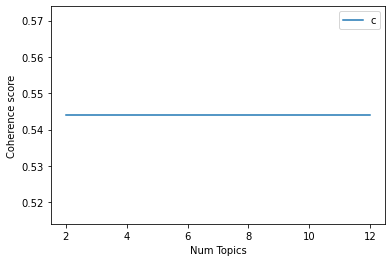

In [16]:
# Show graph
import matplotlib.pyplot as plt

topics_list = [2, 4,6, 8, 10, 12]
plt.plot(topics_list, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Plot Perplexity Scores

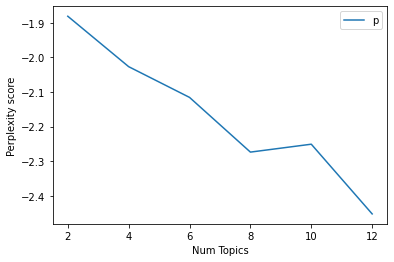

In [17]:
# Show graph
import matplotlib.pyplot as plt

topics_list = [2, 4,6, 8, 10, 12]
plt.plot(topics_list, perplexity_val)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

### Display Results

In [18]:
# Print the coherence scores
topics_list = [6, 8, 10, 12]
for m, cv, pr in zip(topics_list, coherence_values, perplexity_val):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4), " has Perplexity of", round(pr, 4))

Num Topics = 6  has Coherence Value of 0.544  has Perplexity of -1.8807
Num Topics = 8  has Coherence Value of 0.544  has Perplexity of -2.0265
Num Topics = 10  has Coherence Value of 0.544  has Perplexity of -2.1154
Num Topics = 12  has Coherence Value of 0.544  has Perplexity of -2.2736


## Train Model with Best number of topics

In [19]:
best_topic_number = 10
best_model = models.LdaModel(corpus, num_topics=best_topic_number, id2word=dictionary_LDA, passes=40, iterations = 100, alpha=0.05, eta=0.01)
        

In [20]:
coherencemodel = CoherenceModel(model=best_model, texts=text_data, dictionary=dictionary_LDA, coherence='c_v')
coherence_score = coherencemodel.get_coherence()
perplexity_score = best_model.log_perplexity(corpus)
print("Num Topics =", best_topic_number, " has Coherence Value of", round(coherence_score, 4), " has Perplexity of", round(perplexity_score, 4))
        

Num Topics = 10  has Coherence Value of 0.544  has Perplexity of -2.3729


In [28]:
# display all topics with weight of all keywords
for i,topic in best_model.show_topics(formatted=True, num_topics=best_topic_number, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.500*"pfizer" + 0.500*"moderna" + 0.000*"vax" + 0.000*"johnson" + 0.000*"covishield" + 0.000*"borisjohnson" + 0.000*"johnsonandjohnson" + 0.000*"biontech" + 0.000*"teammoderna" + 0.000*"covax"

1: 0.518*"covax" + 0.482*"covishield" + 0.000*"pfizer" + 0.000*"moderna" + 0.000*"vax" + 0.000*"johnson" + 0.000*"borisjohnson" + 0.000*"johnsonandjohnson" + 0.000*"biontech" + 0.000*"teammoderna"

2: 0.661*"biontech" + 0.338*"pfizer" + 0.000*"moderna" + 0.000*"vax" + 0.000*"johnson" + 0.000*"covishield" + 0.000*"borisjohnson" + 0.000*"johnsonandjohnson" + 0.000*"teammoderna" + 0.000*"covax"

3: 1.000*"johnsonandjohnson" + 0.000*"pfizer" + 0.000*"moderna" + 0.000*"vax" + 0.000*"johnson" + 0.000*"covishield" + 0.000*"borisjohnson" + 0.000*"biontech" + 0.000*"teammoderna" + 0.000*"covax"

4: 0.999*"janssen" + 0.000*"pfizer" + 0.000*"moderna" + 0.000*"vax" + 0.000*"johnson" + 0.000*"covishield" + 0.000*"borisjohnson" + 0.000*"johnsonandjohnson" + 0.000*"biontech" + 0.000*"teammoderna"

5: 1.000

# Visulaize Topics

In [22]:
import pyLDAvis.gensim
warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, dictionary=dictionary_LDA, mds='mmds')
vis

C:\Users\hammad\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\hammad\Anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=T

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.060327 -0.218575       1        1  24.658372
5      0.281457 -0.356812       2        1  19.062806
9     -0.485551 -0.113917       3        1  13.832476
1     -0.184953  0.411669       4        1   9.329398
0      0.094499 -0.312887       5        1   9.118157
6      0.484447  0.004475       6        1   7.820478
3      0.105647  0.445497       7        1   5.338918
2     -0.174148 -0.355225       8        1   4.403807
4     -0.406600  0.213938       9        1   3.484079
7      0.345527  0.281837      10        1   2.951508, topic_info=                 Term         Freq        Total Category  logprob  loglift
0              pfizer  3130.000000  3130.000000  Default   11.000  11.0000
1             moderna  2407.000000  2407.000000  Default   10.000  10.0000
5        borisjohnson   797.000000   797.000000  Default    9.000   9.0000
3             johnson   887.000000   887.000000  Default    8.000   8.0000
6   johnsonandjohnson   544.000000   544.000000  Default    7.000   7.0000
..                ...          ...          ...      ...      ...      ...
6   johnsonandjohnson     0.164264   544.387001  Topic10   -7.513  -4.5831
5        borisjohnson     0.164264   797.397163  Topic10   -7.513  -4.9648
3             johnson     0.164264   887.661938  Topic10   -7.513  -5.0720
1             moderna     0.164264  2407.815118  Topic10   -7.513  -6.0699
0              pfizer     0.164264  3130.725354  Topic10   -7.513  -6.3324

[121 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
7         8  0.999539           biontech
5         6  0.999502       borisjohnson
9         4  1.000011              covax
4         4  0.998870         covishield
10        9  0.999724            janssen
3         3  0.999254            johnson
6         7  0.999289  johnsonandjohnson
1         2  0.806956            moderna
1         5  0.192706            moderna
0         1  0.803009             pfizer
0         5  0.148528             pfizer
0         8  0.048551             pfizer
8        10  0.998794        teammoderna
2         3  1.000182                vax, R=11, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 2, 1, 7, 4, 3, 5, 8])

# All Topics Probabilities in each Document

In [23]:
# convert all probability distribution into dataframe (we are doing this to also keep topics having 0 probability)
# In other case topics having 0 probability will be misleading
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res


In [24]:
# find topic probabilities that model assign to all documents
topics = [best_model[corpus[i]] for i in range(len(text_data))]

In [25]:
# make dataframe of all document probability distribution
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=best_topic_number) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [26]:
document_topic.head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.700000,0.033333
3,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
4,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.700000,0.033333
5,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
6,0.033333,0.033333,0.033333,0.033333,0.033333,0.700000,0.033333,0.033333,0.033333,0.033333
7,0.033333,0.033333,0.033333,0.033333,0.033333,0.700000,0.033333,0.033333,0.033333,0.033333
8,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.700000,0.033333
9,0.020000,0.020000,0.020000,0.020000,0.020000,0.820000,0.020000,0.020000,0.020000,0.020000


# Calculate and Find Keywords in each Document


In [27]:
def format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=text_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Per_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=text_data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.10,"pfizer, moderna, vax, johnson, covishield, bor...",[astrazeneca]
1,1,0.0,0.10,"pfizer, moderna, vax, johnson, covishield, bor...",[astrazeneca]
2,2,8.0,0.70,"pfizer, moderna, vax, johnson, covishield, bor...",[pfizer]
3,3,0.0,0.10,"pfizer, moderna, vax, johnson, covishield, bor...",[astrazeneca]
4,4,8.0,0.70,"pfizer, moderna, vax, johnson, covishield, bor...",[pfizer]
5,5,0.0,0.10,"pfizer, moderna, vax, johnson, covishield, bor...",[astrazeneca]
6,6,5.0,0.70,"moderna, pfizer, vax, johnson, covishield, bor...",[moderna]
7,7,5.0,0.70,"moderna, pfizer, vax, johnson, covishield, bor...",[moderna]
8,8,8.0,0.70,"pfizer, moderna, vax, johnson, covishield, bor...",[pfizer]
9,9,5.0,0.82,"moderna, pfizer, vax, johnson, covishield, bor...","[moderna, moderna]"
